In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [9]:
df_cnvs_per_cell = pd.read_csv('data/cnvs_per_cell.csv')

In [10]:
df_cnvs_per_cell

,tumor,expansion,type,count
0,3430_NT_T2,NaN,non-expanding,1
1,3430_NT_T2,NaN,non-expanding,6
2,3430_NT_T2,NaN,non-expanding,6
3,3430_NT_T2,NaN,non-expanding,3
4,3430_NT_T2,NaN,non-expanding,3
...,...,...,...,...
29606,3730_NT_T2,1.0,expanding,13
29607,3730_NT_T2,1.0,expanding,6
29608,3730_NT_T2,1.0,expanding,13
29609,3730_NT_T2,1.0,expanding,17


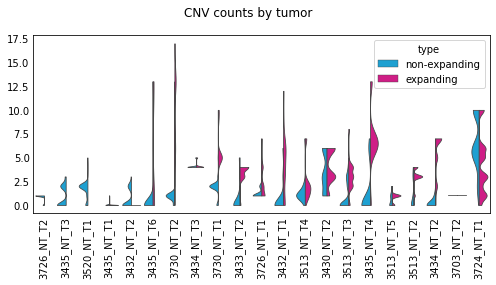

In [13]:
order = [
    '3726-T2',
    '3435-T3',
    '3520-T1',
    '3435-T1',
    '3432-T2',
    '3435-T6',
    '3730-T2',
    '3434-T3',
    '3730-T1',
    '3433-T2',
    '3726-T1',
    '3432-T1',
    '3513-T4',
    '3430-T2',
    '3513-T3',
    '3435-T4',
    '3513-T5',
    '3513-T2',
    '3434-T2',
    '3703-T2',
    '3724-T1',
]
order = ['{}_NT_{}'.format(*o.split('-')) for o in order]

df_counts = df_cnvs_per_cell[df_cnvs_per_cell['count'] < 20]
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
fig.suptitle('CNV counts by tumor')
sns.violinplot(
    x='tumor',
    y='count',
    hue='type',
    data=df_counts,
    split=True,
    linewidth=0.8,
    palette=['#00aeef','#ec008c'],
    cut=0,
    order=order,
    inner=None,
    ax=ax,
)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.tick_params(axis='both', which='both', length=0)
_ = ax.set_xticklabels(order, rotation=90)

In [32]:
def permutation_test(values1, values2, n):
    combined = np.array(list(values1) + list(values2))
    permutations = []
    for _ in range(n):
        np.random.shuffle(combined)
        permutation1 = combined[:len(values1)]
        permutation2 = combined[len(values1):]
        permutations.append(np.mean(permutation1) - np.mean(permutation2))
    return (np.array(permutations) >= (np.mean(values1) - np.mean(values2))).sum() / n

rows = []
for tumor, df_part in df_cnvs_per_cell.groupby('tumor'):
    if df_part['type'].nunique() != 2:
        continue
    
    expanding_counts = df_part[df_part['type'] == 'expanding']['count'].values
    non_expanding_counts = df_part[df_part['type'] == 'non-expanding']['count'].values
    permutation_p = permutation_test(
        expanding_counts, non_expanding_counts, 10000
    )
    whitney_p = stats.mannwhitneyu(
        expanding_counts, non_expanding_counts, alternative='greater'
    )[1]
    rows.append([tumor, permutation_p, whitney_p])
pd.DataFrame(rows, columns=['tumor', 'permutation_p', 'whitney_p'])

,tumor,permutation_p,whitney_p
0,3430_NT_T2,0.0037,4.743205e-03
1,3432_NT_T1,0.0000,8.560973e-13
2,3432_NT_T2,1.0000,9.999915e-01
3,3433_NT_T2,0.0000,2.114465e-31
4,3434_NT_T2,0.0000,5.739590e-74
5,3434_NT_T3,0.0066,5.725371e-03
6,3435_NT_T1,1.0000,9.977661e-01
7,3435_NT_T4,0.0000,9.966362e-22
8,3435_NT_T6,0.0000,1.505750e-10
9,3513_NT_T2,0.0000,2.852887e-43


[Text(0, 0, 'non-expanding\nn=6018'), Text(1, 0, 'expanding\nn=23578')]

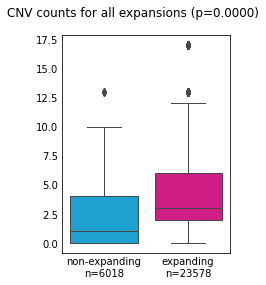

In [34]:
df_counts = df_cnvs_per_cell[df_cnvs_per_cell['count'] < 20]
values = df_counts['count'].values
expanding_mask = df_counts['type'] == 'expanding'
non_expanding_mask = df_counts['type'] == 'non-expanding'
n_expanding = np.sum(expanding_mask)
n_non_expanding = np.sum(non_expanding_mask)
bootstraps = []
for i in range(10000):
    bootstrap_expanding_counts = np.random.choice(values, size=n_expanding)
    bootstrap_non_expanding_counts = np.random.choice(values, size=n_non_expanding)
    bootstraps.append(np.mean(bootstrap_expanding_counts) - np.mean(bootstrap_non_expanding_counts))
p = np.sum(np.array(bootstraps) >= np.mean(
    df_counts[expanding_mask]['count'].values
) - np.mean(
    df_counts[non_expanding_mask]['count'].values
))
    
fig, ax = plt.subplots(figsize=(3, 4), tight_layout=True)
fig.suptitle(f'CNV counts for all expansions (p={p:.4f})')
sns.boxplot(
    x='type',
    y='count',
    data=df_counts,
    palette=['#00aeef','#ec008c'],
    ax=ax,
    linewidth=1
)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.tick_params(axis='both', which='both', length=0)
ax.set_xticklabels([
   f'non-expanding\nn={n_non_expanding}', f'expanding\nn={n_expanding}'
])
